In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyspark as ps
import os
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
import pickle as pickle
import time
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from implicit.nearest_neighbours import bm25_weight
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
import spotipy
import sys
from spotipy.oauth2 import SpotifyClientCredentials
#spark = SparkSession.builder.master("local").config(conf=SparkConf()).getOrCreate()



client_id = 'f819c567a61446968b9741eefca13a3d'
client_secret = '18a418663f664e6c94e546f8a21a7e1f'

spotify = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id,
                                                                client_secret=client_secret))



In [8]:
file = pd.read_csv('../../dirty_data/MLHD-SS-00/MLHD_000/0a584e23-8f19-4cc6-9ce9-6b7926fdeb27.txt.gz', sep = '\t', header = None, index_col = 0)

In [13]:
file = file.rename(columns = {0:"timestamp",1: "artist-MBID", 2:"release-MBID", 3:"recording-MBID"})
file.dropna()

artist-MBID  \
0                                                  
1251653828  81b9963b-7ff7-47f7-9afb-fe454d8db43c   
1251654021  81b9963b-7ff7-47f7-9afb-fe454d8db43c   
1251828123  cdc62516-147c-41a0-9a2c-9d24cccf91cd   
1251838342  81b9963b-7ff7-47f7-9afb-fe454d8db43c   
1251838557  81b9963b-7ff7-47f7-9afb-fe454d8db43c   
...                                          ...   
1355378973  455aca99-38f3-47cb-aa6b-820cf9de3c91   
1355567591  455aca99-38f3-47cb-aa6b-820cf9de3c91   
1355685891  81b9963b-7ff7-47f7-9afb-fe454d8db43c   
1355686335  81b9963b-7ff7-47f7-9afb-fe454d8db43c   
1355686550  81b9963b-7ff7-47f7-9afb-fe454d8db43c   

                                    release-MBID  \
0                                                  
1251653828  0198aa84-9a91-339a-9f0d-bc07cb6f47cd   
1251654021  1301e2cd-7398-3206-9ae2-b6ac47ec348c   
1251828123  857583d7-746b-454f-9e43-2ed8b7ae027a   
1251838342  1301e2cd-7398-3206-9ae2-b6ac47ec348c   
1251838557  1301e2cd-7398-3206-9ae2-b6ac47ec348c   
...                                          ...   
1355378973  54359359-f14f-3269-868d-0a4a1d2ff301   
1355567591  54359359-f14f-3269-868d-0a4a1d2ff301   
1355685891  0198aa84-9a91-339a-9f0d-bc07cb6f47cd   
1355686335  0198aa84-9a91-339a-9f0d-bc07cb6f47cd   
1355686550  0198aa84-9a91-339a-9f0d-bc07cb6f47cd   

                                  recording-MBID  
0                                                 
1251653828  0a4bc019-1bb1-4e52-906e-80926861f656  
1251654021  0ad9912f-3cf7-40a3-9a12-0f7e90297d94  
1251828123  4d1524b1-0b0f-477b-ad3f-97f2ad8ca26d  
1251838342  097fb086-e3d7-4572-ab04-3f0f0c46229d  
1251838557  34278e1e-4fd6-4f9b-a741-d1fe6a50b48f  
...                                          ...  
1355378973  24d79792-1fa1-4576-8a52-90e856e5efa0  
1355567591  49581db0-ba74-4823-ae77-7079030ef389  
1355685891  0a4bc019-1bb1-4e52-906e-80926861f656  
1355686335  03f78393-3254-438e-8f9d-af0c141aefe4  
1355686550  41ef6311-5e97-44a6-bd87-254abf9cf43a  

[6723 rows x 3 columns]

# Load Dataset

In [3]:
def load_datasets():
    
    test_data = pd.read_pickle('../../cleaned_data/usa_users.pkl')    

    return (test_data)

In [4]:
test_data = load_datasets()

In [5]:
test_data

count                              userMBID  \
0            1  76c19d9a-d3d1-4b98-b003-51235bf16c0e   
1            1  a741c7b6-b52e-4351-959f-bcfafa3c8adc   
2            3  70e29d38-9cf0-40f3-9b65-20cee0b2f601   
3            1  0eb83ccf-af39-49d4-bfac-254e7fdaec6a   
4            1  951542ba-40a0-4c85-8da1-eb8fd3fb0804   
...        ...                                   ...   
2534539      2  2266f5d0-2ebf-4cf9-a40f-5ea05082766f   
2534540      3  c182c8c7-c1df-4259-9a42-1ce81f8610bd   
2534541      3  c46bf9b0-1f6c-435c-af8a-72c623d8ec69   
2534542      5  5fa1515e-549e-47bc-b409-b150ce9b159c   
2534543      7  c1cdba04-14c4-422c-bb61-449509202383   

                                recordingMBID                 trackName  \
0                                        None                      None   
1        00020316-d32d-49c2-8ea3-2177c62de66b           Entre deux feux   
2        0006867e-b3a3-4f1c-9cb3-89a34086c7ff                 Albatross   
3        0006867e-b3a3-4f1c-9cb3-89a34086c7ff                 Albatross   
4        0006867e-b3a3-4f1c-9cb3-89a34086c7ff                 Albatross   
...                                       ...                       ...   
2534539  ffe681f5-71af-4526-8735-c9240cf96ffa                Summertime   
2534540  ffe681f5-71af-4526-8735-c9240cf96ffa                Summertime   
2534541  ffeb7251-bb74-4e6a-b62a-e6ab9dc123d7  900 Million People Daily   
2534542  fff37a5b-6e88-4ff5-95c6-c323570b9c54             Night Prowler   
2534543  fff37a5b-6e88-4ff5-95c6-c323570b9c54             Night Prowler   

         userID  trackID  
0             0        0  
1             1        1  
2             2        2  
3             3        2  
4             4        2  
...         ...      ...  
2534539    3327  3786958  
2534540    3329  3786958  
2534541    3654  3786959  
2534542    3367  3786960  
2534543    3550  3786960  

[19370395 rows x 6 columns]

# EDA

                                      count
recordingMBID                              
0b1bcb26-0fcd-4094-aee1-e80232e657d2  20634
b6905296-548e-4326-bc42-02ee5f7be086  19447
573c180e-4bf5-49b7-86e0-4b300eed735e  18117
ec049703-9a04-4c45-bc08-8094a918c156  18061
6df6ea4d-4687-4d1c-9f81-0719f644e05b  17014


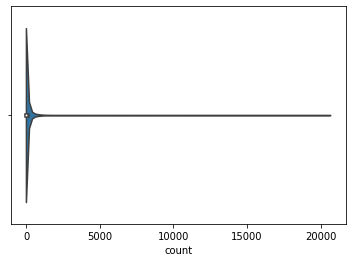

In [7]:
# Prints the top 5 most listened to songs by all users
print(test_data.groupby('recordingMBID').agg({'count':'sum'}).sort_values('count', ascending = False)[:5])

sns.violinplot(test_data.groupby('recordingMBID').agg({'count':'sum'}).sort_values('count', ascending = False)['count'])
plt.show()

In [150]:
# Number of songs only listened to once.
(test_data.groupby('recordingMBID').agg({'count':'sum'})['count'] == 1).value_counts()

False    67722
True     42312
Name: count, dtype: int64

In [152]:
print('number of unique songs: ', len(test_data['recordingMBID'].unique()))

number of unique songs:  110035


In [8]:
print('number of unique users: ', len(test_data['userID'].unique()))

number of unique users:  3785


0b1bcb26-0fcd-4094-aee1-e80232e657d2    1571
21a40099-7897-4439-a959-56a192d4b28f    1505
12e977fa-fa7e-41cd-a824-db038ec8216b    1484
199b3b15-1094-4a18-a239-aeb8e5172d13    1460
b6905296-548e-4326-bc42-02ee5f7be086    1429
Name: recordingMBID, dtype: int64


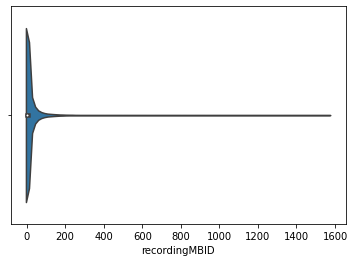

In [10]:
print(test_data['recordingMBID'].value_counts().sort_values(ascending = False)[:5])
sns.violinplot(test_data['recordingMBID'].value_counts().sort_values(ascending = False))
plt.show()

# Obtain Model

In [11]:
from ipynb.fs.full.Model_Creation import create_model

In [12]:
model, user_plays = create_model(test_data[['userID','trackID','count']], False)

# Test Model

# Recommendation System

In [14]:
# Get recommendations for the a single user
userid = 0
ids, scores = model.recommend(userid, user_plays[userid], N=10, filter_already_liked_items=False)

In [17]:
unique_tracks = test_data.drop_duplicates(subset = ["trackID"])
unique_tracks = unique_tracks[['trackID','recordingMBID', 'trackName']].set_index('trackID')
#results = unique_tracks[unique_tracks['trackID'].isin(ids)].sort_values(by = ['trackID'])

In [20]:
results = pd.DataFrame(unique_tracks.loc[ids])
results['confidence'] = scores
results['already_liked'] = np.in1d(ids, user_plays[userid].indices)

In [21]:
results

recordingMBID  \
trackID                                         
3272883                                  None   
1116674                                  None   
0                                        None   
535      0497ef20-b864-499e-a255-95b19ddd5228   
735      0671d41a-6ea3-4a8e-84f3-5f6515c7e707   
182      01754f6c-873f-4af7-9554-59784d61e4c7   
602      051d69b3-e8be-4ede-a3ba-fe32d85aac3d   
885      07c2bb6a-ae02-49db-b599-8bda5e719334   
757      06a62f0d-0519-4c0e-8b8e-decfdc60a6ba   
135      011c5e2a-ab9c-4f63-979e-2df16863dcd5   

                                                 trackName  confidence  \
trackID                                                                  
3272883                                               None    2.295934   
1116674                                               None    1.418686   
0                                                     None    0.996525   
535                                   Yesterday’s Feelings    0.984269   
735                                              Handcuffs    0.965886   
182      Concerning the UFO Sighting Near Highland, Ill...    0.953057   
602                                       Strawberry Swing    0.938722   
885                                              You and I    0.938160   
757                                             Bike Scene    0.936683   
135                                           January 1979    0.927844   

         already_liked  
trackID                 
3272883          False  
1116674          False  
0                 True  
535               True  
735               True  
182               True  
602               True  
885               True  
757               True  
135               True

In [24]:
def lookup_artist(name):
    results = spotify.search(q='artist:' + name, type='artist')
    items = results['artists']['items']
    print(results.keys())
    if len(items) > 0:
        artist = items[0]
    return(artist)
        
        
def lookup_track(name):
    if name == None:
        return(None)
    results = spotify.search(q='track:' + name, type='track')
    items = results['tracks']['items']
    if len(items) > 0:
        track = items[0]
        return(track)
    else:
        print("track not found")
        return(None)
    

    #return(results)

In [33]:
def get_audio_features(results):
    
    pred = []
    for track in results['trackName']:
        if track != np.nan:
            spoti_track = lookup_track(track)
            if spoti_track != None:
                pred.append(spotify.audio_features(spoti_track['uri'])[0])


    max_iter = 50
    if len(test_data) < 50:
        max_iter = len(test_data)

    res = []

    tracks = test_data[test_data['userID'] == userid].sort_values('count')[:100]['trackName'].values
    for track in tracks:
        if type(track) != float:
            spoti_track = lookup_track(track)
            if spoti_track != None:                
                res.append(spotify.audio_features(spoti_track['uri'])[0])
    pred = pd.DataFrame(pred)
    res = pd.DataFrame(res)
    filtered_res = res[['danceability','energy', 'loudness', 'speechiness', 'valence', 'tempo']]
    filtered_pred = pred[['danceability','energy', 'loudness', 'speechiness', 'valence', 'tempo']]
    return(filtered_pred,filtered_res)


pred, res = get_audio_features(results)

track not found
track not found
track not found
track not found
track not found


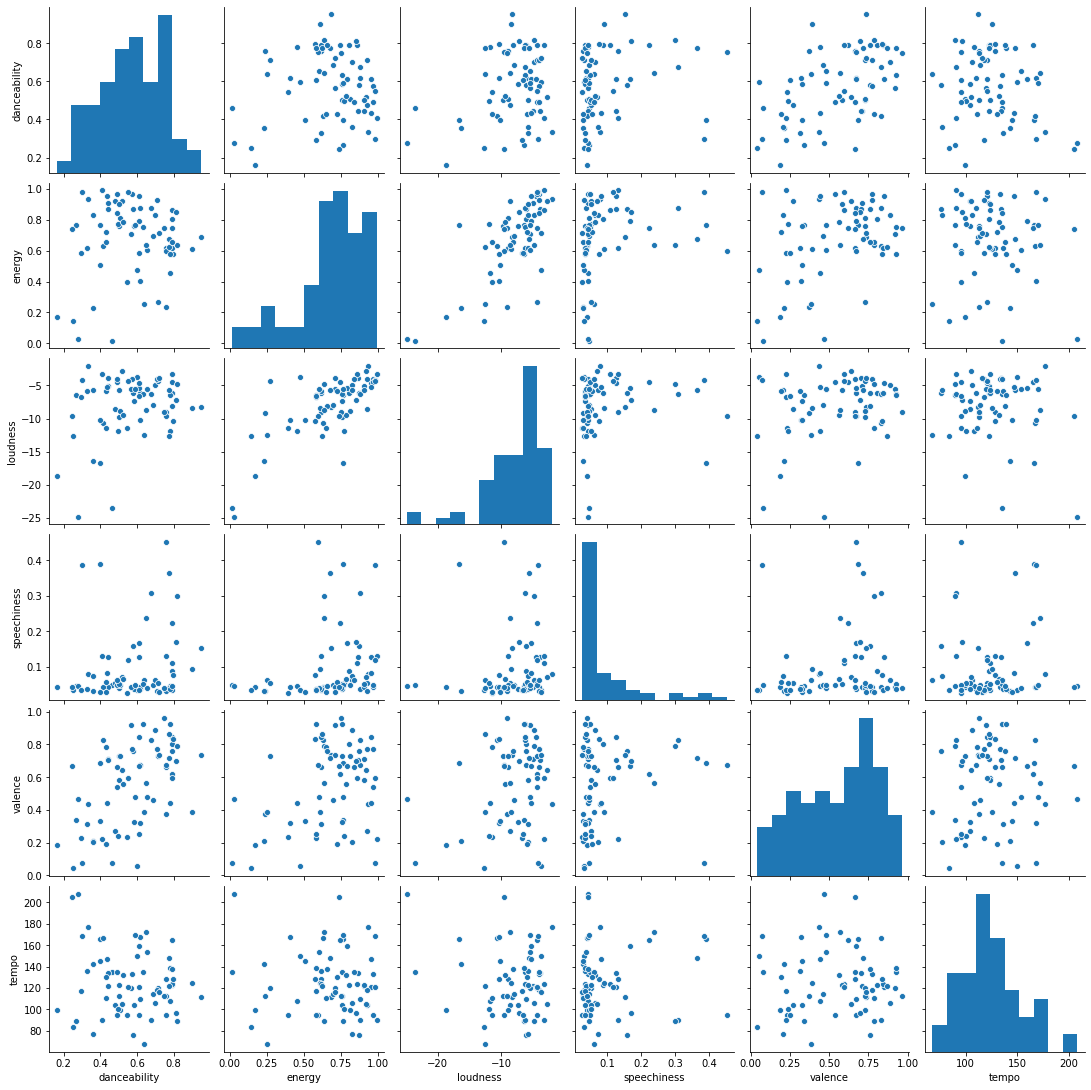

In [35]:
sns.pairplot(res)

       danceability     energy        key   loudness       mode  speechiness  \
count     67.000000  67.000000  67.000000  67.000000  67.000000    67.000000   
mean       0.521370   0.609919   4.940299  -9.011731   0.671642     0.063591   
std        0.169473   0.280525   3.609250   6.284520   0.473160     0.044203   
min        0.099800   0.043600   0.000000 -31.250000   0.000000     0.027100   
25%        0.412500   0.395500   2.000000 -11.187500   0.000000     0.035200   
50%        0.537000   0.655000   5.000000  -6.547000   1.000000     0.048300   
75%        0.614000   0.885000   8.000000  -4.926000   1.000000     0.070500   
max        0.848000   0.995000  11.000000  -2.174000   1.000000     0.274000   

       acousticness  instrumentalness   liveness    valence       tempo  \
count     67.000000      6.700000e+01  67.000000  67.000000   67.000000   
mean       0.296486      1.495857e-01   0.199164   0.442210  119.788537   
std        0.355243      3.039037e-01   0.157583   0.2

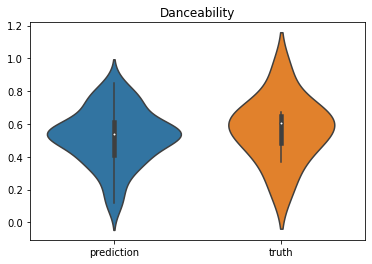

In [107]:
print(res.describe())
print(pred.describe())
ax = sns.violinplot(data = [res['danceability'], pred['danceability']]).set(title='Danceability', xticklabels = ['prediction','truth'])
#ax.set_xticklabels(['prediction','truth'])

In [59]:
def plot_similarity(pred,res):
    plt.scatter([data['danceability'] for data in res], 'k-')
    plt.show()
    
plot_similarity(pred,res)

TypeError: list indices must be integers or slices, not str

In [46]:
res

[[{'danceability': 0.289,
   'energy': 0.321,
   'key': 10,
   'loudness': -8.569,
   'mode': 0,
   'speechiness': 0.0353,
   'acousticness': 0.935,
   'instrumentalness': 0,
   'liveness': 0.108,
   'valence': 0.214,
   'tempo': 111.841,
   'type': 'audio_features',
   'id': '7mbGvJnVHPnT8WCR0Nmlgz',
   'uri': 'spotify:track:7mbGvJnVHPnT8WCR0Nmlgz',
   'track_href': 'https://api.spotify.com/v1/tracks/7mbGvJnVHPnT8WCR0Nmlgz',
   'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7mbGvJnVHPnT8WCR0Nmlgz',
   'duration_ms': 145714,
   'time_signature': 3}]]

In [82]:
test_data[test_data['artistID'].isin(ids)]['artistName'].unique()

array(['Duke Ellington', 'The Avett Brothers', 'of Montreal',
       'Neutral Milk Hotel', 'O.A.R.', nan,
       'Tom Petty and the Heartbreakers', 'The Crystal Method', 'Boston',
       'Ben Harper'], dtype=object)

In [1]:
def measure_performance(ids, scores, test_data, userid, performance_metric):
    predicted = []
    for artist in test_data[test_data['artistID'].isin(ids)]['artistName'].unique():
        predicted.append(lookup_artist(artist))
    
    test = []
    for artist in test_data[test_data['userID'] == userid].sample(50)['artistName']:
        test.append(lookup_artist(artist))
    
    score = performance_metric(predicted,test)
    
    return(score)
        
measure_performance(0,0,test_data,0)

NameError: name 'test_data' is not defined

In [ ]:
def test_model(model, n_tests, test_data):
    
    recommendation_performance = []
    if n_tests < len(test_data['userID'].unique):
        test_ids = test_data.sample(n_tests)['id']
    
    
    for userid in test_ids:
        ids, scores = model.recommend(userid, user_plays[userid], N=10, filter_already_liked_items=False)
        recommendation_performance.append(measure_performance(ids, scores, test_data, userid))
    
    return(recommendation_performance/n_tests)
    
    
    

In [73]:
spotify

external_urls  \
0     {'spotify': 'https://open.spotify.com/artist/1...   
1     {'spotify': 'https://open.spotify.com/artist/1...   
2     {'spotify': 'https://open.spotify.com/artist/2...   
3     {'spotify': 'https://open.spotify.com/artist/4...   
4     {'spotify': 'https://open.spotify.com/artist/2...   
...                                                 ...   
1294  {'spotify': 'https://open.spotify.com/artist/4...   
1295  {'spotify': 'https://open.spotify.com/artist/6...   
1296  {'spotify': 'https://open.spotify.com/artist/4...   
1297  {'spotify': 'https://open.spotify.com/artist/2...   
1298  {'spotify': 'https://open.spotify.com/artist/1...   

                             followers  \
0      {'href': None, 'total': 359803}   
1      {'href': None, 'total': 932408}   
2     {'href': None, 'total': 2197830}   
3     {'href': None, 'total': 2297042}   
4      {'href': None, 'total': 585961}   
...                                ...   
1294    {'href': None, 'total': 35634}   
1295   {'href': None, 'total': 522595}   
1296      {'href': None, 'total': 320}   
1297   {'href': None, 'total': 120387}   
1298   {'href': None, 'total': 110210}   

                                                 genres  \
0                                [neo mellow, pop rock]   
1     [indie folk, new americana, north carolina ind...   
2     [album rock, classic rock, country rock, hard ...   
3     [album rock, blues rock, classic rock, country...   
4     [alternative rock, anti-folk, chamber pop, ele...   
...                                                 ...   
1294                      [dance rock, electronic rock]   
1295  [adult standards, brill building pop, bubblegu...   
1296                      [ontario indie, ottawa indie]   
1297     [candy pop, glam punk, lilith, power-pop punk]   
1298  [bubblegum pop, classic garage rock, folk rock...   

                                                   href  \
0     https://api.spotify.com/v1/artists/1Cq0LAHFfvU...   
1     https://api.spotify.com/v1/artists/196lKsA13K3...   
2     https://api.spotify.com/v1/artists/29kkCKKGXhe...   
3     https://api.spotify.com/v1/artists/4tX2TplrkIP...   
4     https://api.spotify.com/v1/artists/2ooIqOf4X2u...   
...                                                 ...   
1294  https://api.spotify.com/v1/artists/4xM0Rz2FbjZ...   
1295  https://api.spotify.com/v1/artists/6mcrZQmgzFG...   
1296  https://api.spotify.com/v1/artists/4XcUnFOwmih...   
1297  https://api.spotify.com/v1/artists/2c0qomdZabc...   
1298  https://api.spotify.com/v1/artists/1nyQBzKgZ2h...   

                          id  \
0     1Cq0LAHFfvUTBEtMPXUidI   
1     196lKsA13K3keVXMDFK66q   
2     29kkCKKGXheHuoO829FxWK   
3     4tX2TplrkIP4v05BNC903e   
4     2ooIqOf4X2uz4mMptXCtie   
...                      ...   
1294  4xM0Rz2FbjZevoVLVJUgEQ   
1295  6mcrZQmgzFGRWf7C0SObou   
1296  4XcUnFOwmihunLCK48vq77   
1297  2c0qomdZabcCyqTZ5M9msd   
1298  1nyQBzKgZ2hBLr7PnyV7cI   

                                                 images  \
0     [{'height': 640, 'url': 'https://i.scdn.co/ima...   
1     [{'height': 640, 'url': 'https://i.scdn.co/ima...   
2     [{'height': 1000, 'url': 'https://i.scdn.co/im...   
3     [{'height': 640, 'url': 'https://i.scdn.co/ima...   
4     [{'height': 662, 'url': 'https://i.scdn.co/ima...   
...                                                 ...   
1294  [{'height': 640, 'url': 'https://i.scdn.co/ima...   
1295  [{'height': 640, 'url': 'https://i.scdn.co/ima...   
1296  [{'height': 640, 'url': 'https://i.scdn.co/ima...   
1297  [{'height': 1200, 'url': 'https://i.scdn.co/im...   
1298  [{'height': 640, 'url': 'https://i.scdn.co/ima...   

                                  name  popularity    type  \
0                               O.A.R.          57  artist   
1                   The Avett Brothers          60  artist   
2                               Boston          65  artist   
3      Tom Petty and the Heartbreakers          67  artist   
4     

In [45]:
searches

['artist:Third Eye Blind',
 'artist:Tom Waits',
 'artist:Mos Def',
 'artist:Tanlines',
 'artist:Duke Ellington',
 'artist:Noah and the Whale',
 'artist:Dire Straits',
 'artist:Glenn Miller',
 'artist:Death From Above 1979',
 'artist:Tom Petty and the Heartbreakers']

In [58]:
ids, scores= model.similar_items(1961)

In [60]:
similar = pd.DataFrame(artist_directory.iloc[ids])
similar['confidence'] = scores
similar['already_liked'] = np.in1d(ids, user_plays[userid].indices)
similar

MBID      pkID  \
1961  f93dbc64-6f08-4033-bcc7-8a0bb4689849   11050.0   
815   0c502791-4ee9-4c5f-9696-0602b721ff3b    2116.0   
2088  c7423e0c-ab3e-4ab4-be10-cdff5a9d3062    1601.0   
48    3abfc8cc-00f0-41c7-a3d0-58054feae415  888872.0   
6     5ca3f318-d028-4151-ac73-78e2b2d6cdcc     196.0   
499   22dc19af-d085-4c9b-adfb-22ec256251f1    2531.0   
131   531c7210-0583-4380-85f9-eac1b667f1e0       NaN   
940   ebd2ac91-6249-4e4b-bde1-353a424138c9     506.0   
1361  34cf95c7-4be9-4efd-a48a-c2ea4a0bb114    2715.0   
648   97b1142f-c71e-4971-8736-4a8ceaf6b4c3   53178.0   

                               Artist  confidence  already_liked  
1961  Tom Petty and the Heartbreakers    1.000000          False  
815          Electric Light Orchestra    0.744453           True  
2088                 Blue Öyster Cult    0.727095          False  
48                           the BAND    0.725736           True  
6                           Tom Petty    0.721667           True  
499               Buffalo Springfield    0.719671           True  
131                               NaN    0.714804           True  
940                             Eve 6    0.712772           True  
1361                          America    0.710640           True  
648                  The Decemberists    0.710593           True

In [ ]:
# Could add how many times they have listened to the song.

In [ ]:
# Need to automate it for each user. 

In [10]:
song_count = pd.read_pickle('../../cleaned_data/song_count.pkl')

In [11]:
song_count

recording-MBID  count  \
0    185c98a8-4b69-4cc1-b668-0f24dc7457b1     32   
1    fd1a3ea9-8917-4daa-b06c-41e2d86d4fb4     22   
2    4dad5289-ae58-481d-a6e2-fd4dc1200e98      1   
3    78ab6c7e-c61a-4095-9843-39d1ac783a0e     16   
4    3f9262f0-1754-4b49-96c0-d0bac0587a27      7   
..                                    ...    ...   
854  862c909f-4a65-4658-826d-fb6f2518fac5      2   
855  06b391b4-2ae0-4cc0-841e-bf0a626746c8     29   
856  10f70ec9-271b-4385-aca8-28b2217de304     26   
857  11399c53-bb9c-4283-a691-bf960ded755b      1   
858  ef24dc16-95fd-4cf2-9ae3-fa99676a4311      4   

                                     uuid  
0    159dcabc-2235-4469-82f9-84bc681d2deb  
1    159dcabc-2235-4469-82f9-84bc681d2deb  
2    159dcabc-2235-4469-82f9-84bc681d2deb  
3    159dcabc-2235-4469-82f9-84bc681d2deb  
4    159dcabc-2235-4469-82f9-84bc681d2deb  
..                                    ...  
854  7f1e0a8d-3ee2-4dcf-b357-cd1218aee561  
855  7f1e0a8d-3ee2-4dcf-b357-cd1218aee561  
856  7f1e0a8d-3ee2-4dcf-b357-cd1218aee561  
857  7f1e0a8d-3ee2-4dcf-b357-cd1218aee561  
858  7f1e0a8d-3ee2-4dcf-b357-cd1218aee561  

[2951449 rows x 3 columns]

In [21]:
import random
def null_model(directory, n_samples):
    recommendations = random.sample(list(directory.keys), n_samples)
    return(recommendations)

In [128]:
def load_pride_playlists():
    pride_tracks = []
    pride_playlist = spotify.playlist('37i9dQZF1DX59HcpGmPXYR')
    for track in pride_playlist['tracks']['items']:
        pride_tracks.append(spotify.audio_features(track['track']['uri'])[0])
    pride_tracks = pd.DataFrame(pride_tracks)
    return(pride_tracks)
pp = load_pride_playlists()  

In [129]:
pp

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0          0.672   0.855    9    -3.764     1       0.0397       0.02100   
1          0.643   0.807   10   -12.973     1       0.0319       0.04550   
2          0.862   0.402    4   -12.075     1       0.0368       0.04780   
3          0.728   0.863    2    -4.670     0       0.0675       0.01390   
4          0.695   0.884    6    -2.278     0       0.0753       0.05610   
5          0.788   0.945    9    -5.091     1       0.0599       0.22300   
6          0.709   0.824    1    -8.824     1       0.0453       0.20700   
7          0.720   0.828    5    -9.211     1       0.0462       0.18500   
8          0.587   0.828   11    -5.108     1       0.1610       0.00327   
9          0.543   0.870    9    -6.514     1       0.0428       0.35800   
10         0.687   0.865    6    -4.663     1       0.0349       0.07430   
11         0.675   0.885    8    -2.848     1       0.0487       0.01460   
12         0.603   0.886    0    -7.301     0       0.0465       0.04180   
13         0.756   0.698    6    -6.846     0       0.1120       0.06820   
14         0.627   0.690   10    -5.396     0       0.1390       0.03300   
15         0.781   0.670    3    -3.912     0       0.0452       0.01030   
16         0.667   0.930    7    -4.585     1       0.0608       0.01080   
17         0.675   0.828    0    -5.799     1       0.0454       0.02420   
18         0.710   0.909    2    -2.777     1       0.0639       0.01350   
19         0.729   0.844    5    -8.824     1       0.0344       0.14900   
20         0.737   0.602   11    -5.292     1       0.2040       0.03930   
21         0.685   0.900    5    -4.626     0       0.1510       0.13700   
22         0.583   0.610    5    -5.639     0       0.0382       0.00425   
23         0.737   0.880    6    -6.449     1       0.0433       0.00379   
24         0.675   0.873    5    -7.697     1       0.0441       0.09980   
25         0.746   0.562    0    -8.477     1       0.0287       0.23100   
26         0.637   0.690    1    -4.057     0       0.0405       0.00786   
27         0.474   0.872    4    -4.931     0       0.1090       0.23900   
28         0.652   0.917    6    -6.720     1       0.0548       0.00820   
29         0.649   0.647    9    -7.695     0       0.0452       0.00390   
30         0.792   0.562    7   -11.379     1       0.0929       0.01520   
31         0.700   0.709    7    -5.006     1       0.0838       0.00480   
32         0.768   0.864   11    -6.145     1       0.0324       0.10100   
33         0.776   0.875    4    -5.535     1       0.0575       0.03430   
34         0.720   0.823    0    -7.634     1       0.0268       0.06440   
35         0.837   0.455    5   -15.326     1       0.0354       0.02960   
36         0.784   0.893    7    -5.153     0       0.0923       0.30000   
37         0.616   0.695    9    -5.733     0       0.0423       0.01470   
38         0.789   0.671    7   -10.524     1       0.0440       0.00885   
39         0.690   0.897   11    -4.696     0       0.0506       0.01420   
40         0.621   0.923    2    -3.124     0       0.0321       0.00645   
41         0.820   0.937    5    -4.810     0       0.0549       0.13500   
42         0.564   0.719    1    -5.505     1       0.0475       0.01260   
43         0.660   0.927    5    -5.867     0       0.1560       0.46100   
44         0.777   0.725    0    -8.681     1       0.0500       0.01310   
45         0.701   0.792    7    -8.644     0       0.0549       0.14200   
46         0.937   0.793   11    -4.431     0       0.1150       0.04530   
47         0.859   0.413    1    -7.399     1       0.1820       0.13200   
48         0.796   0.836    9    -6.632     0       0.0754       0.10600   
49         0.677   0.985    1    -4.678     1       0.0549       0.07000   
50         0.610   0.880    3    -7.407     1       0.0741       0.03990   
51         0.694   0.881    1    -4.053     0       

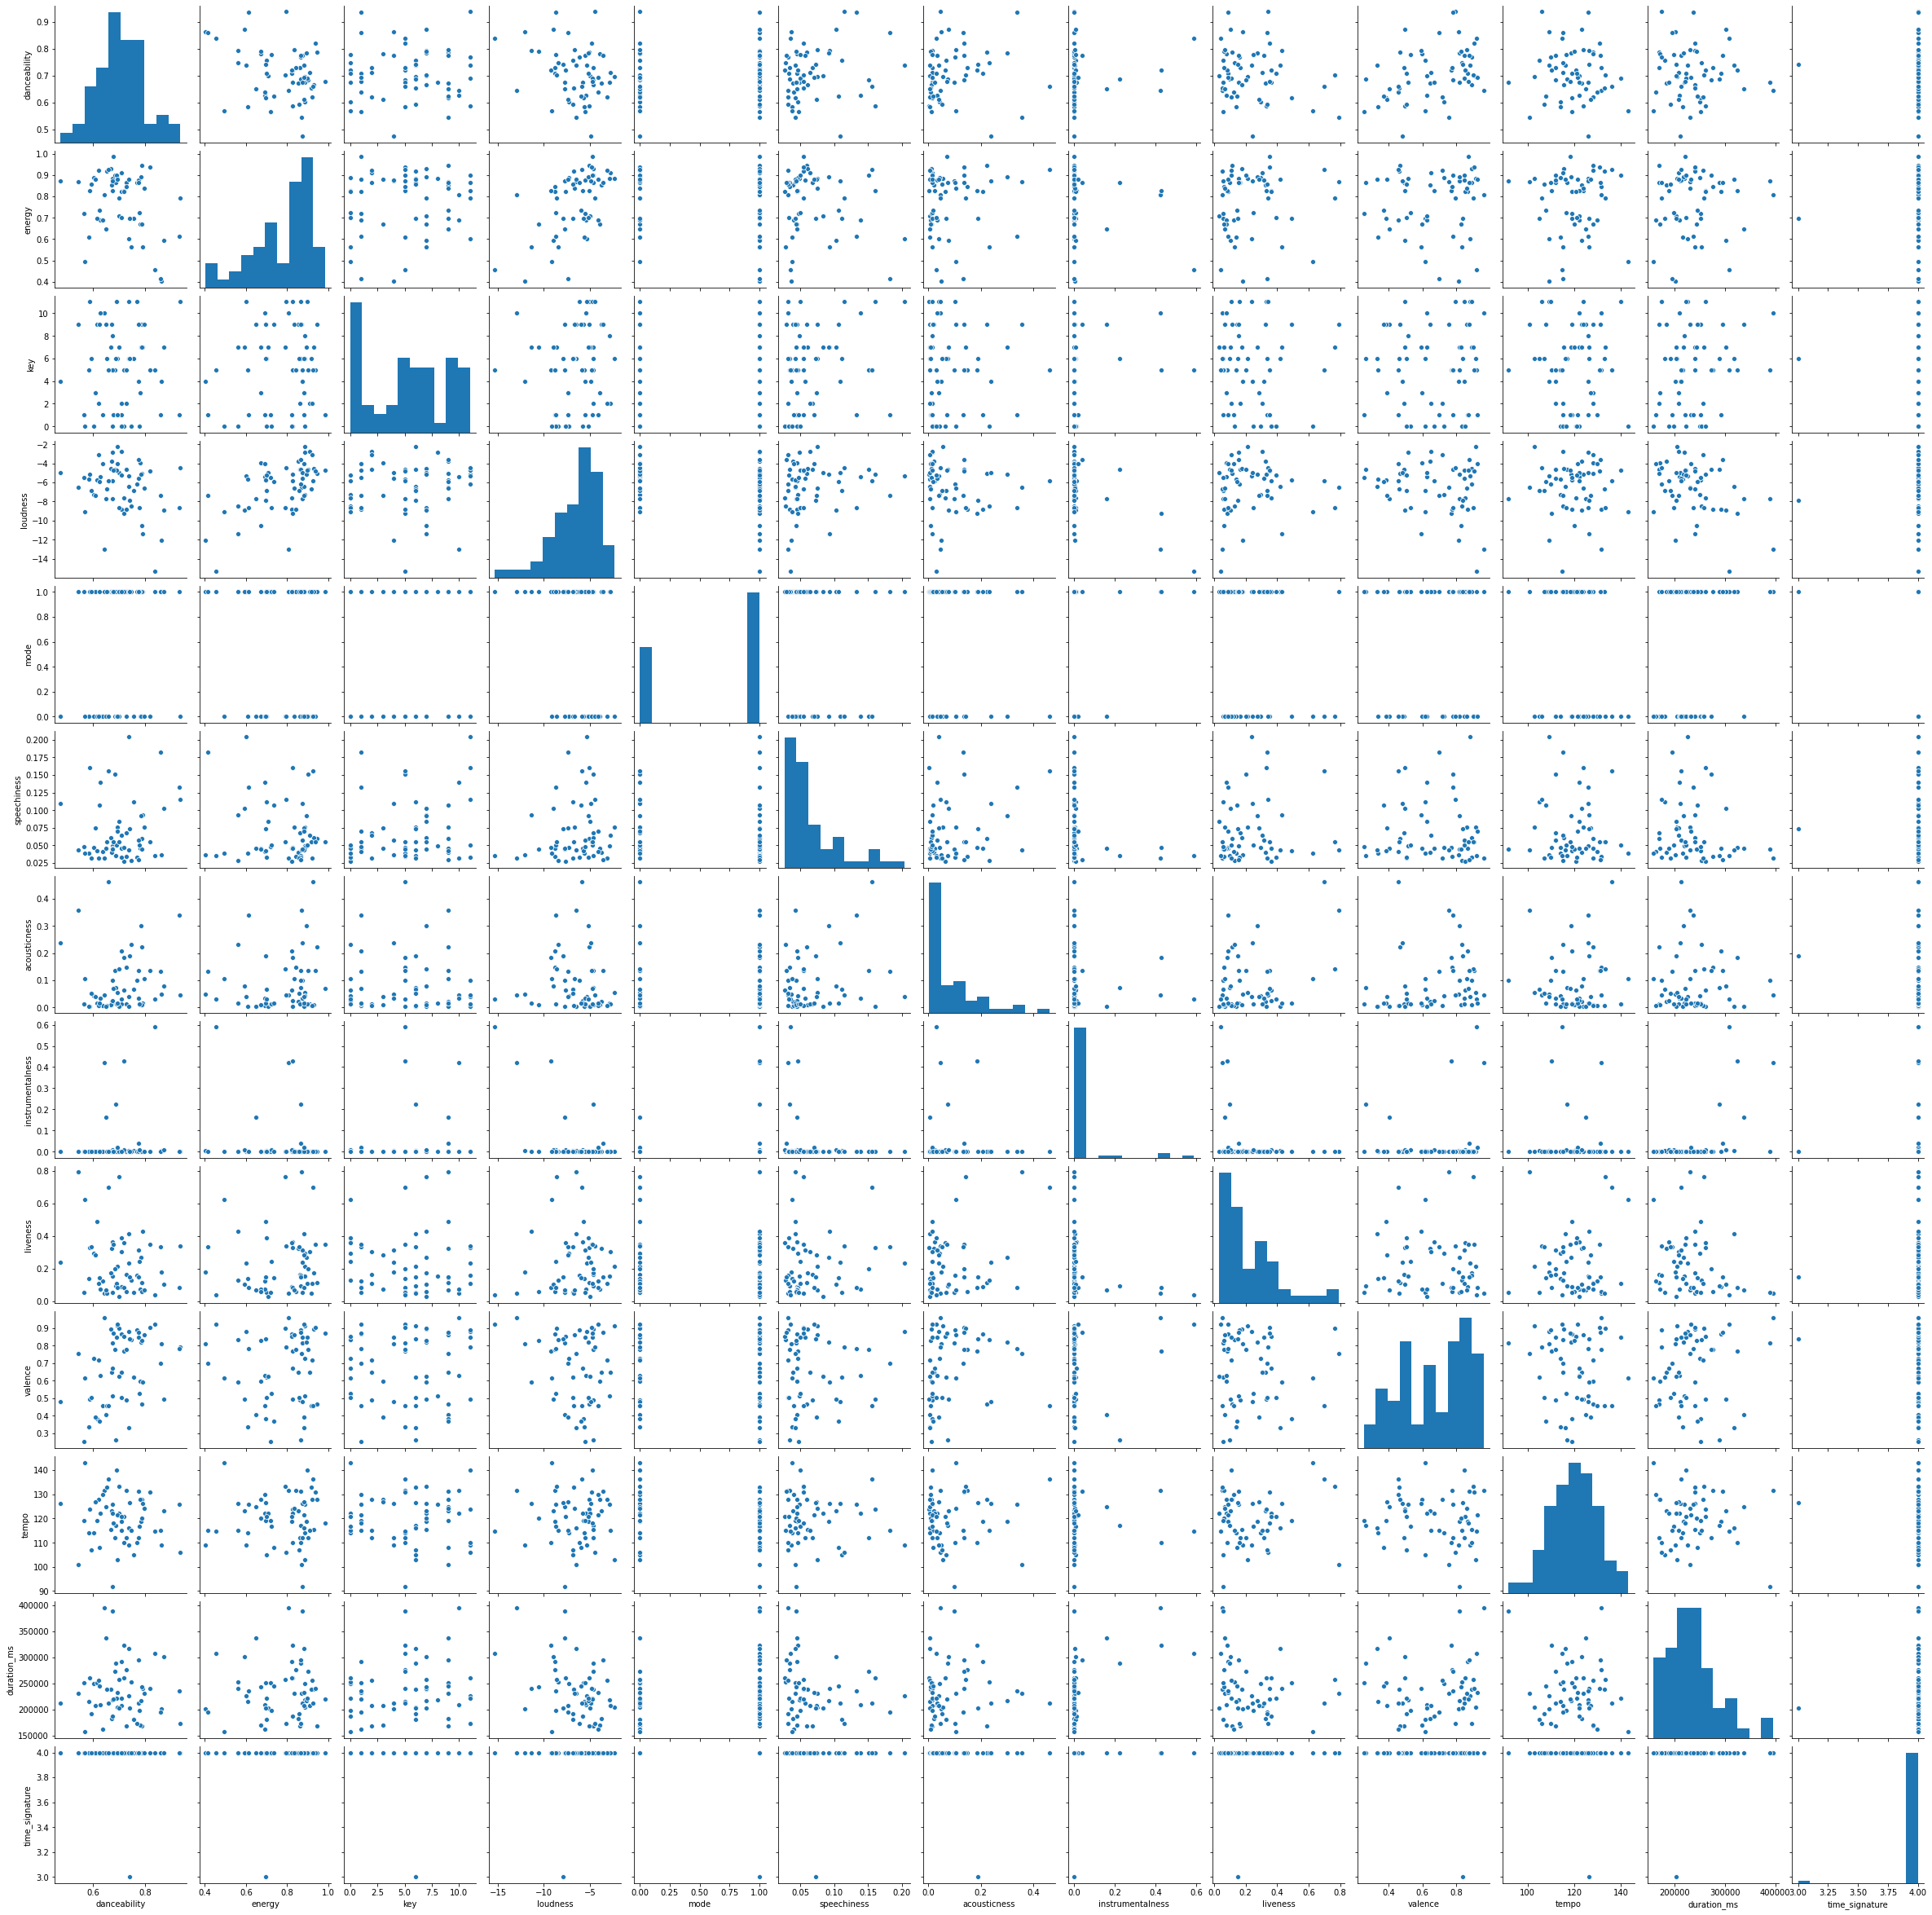

In [130]:
sns.pairplot(pp)

In [4]:
df = pd.read_csv('../../cleaned_data/MLHD_behavioural_features.csv', '\t')

/Users/freddiewoods/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3369: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df

uuid  exploratoryness_artist  \
0       dfb7ea9d-6e4f-48e4-96f6-59abcc207d55                0.963757   
1       a89cb9c5-ba84-424e-8950-16657bb6f7af                0.975727   
2       dde6c339-c256-43f1-94e8-02f4043abdf9                0.841347   
3       44d70878-6e9a-432f-831d-179e8354f448                0.939690   
4       e553ab79-5e93-48fc-aa63-1c4319cafd23                0.956886   
...                                      ...                     ...   
563288  753ae491-366c-4c5c-adf4-923977662e62                0.951364   
563289  a46a1a2d-cf7e-44db-bf14-3ca9ef1945bd                0.758608   
563290  2588d9c4-2bc0-43c8-99e2-e43c8c90a825                0.556925   
563291  87281695-4f34-4268-bdf3-500eaf25a63d                0.870070   
563292  a95448f0-de33-4f06-9c7e-e2965ba733fd                0.876732   

        exploratoryness_album  exploratoryness_track  mainstreamness_artist  \
0                    0.973318               0.993622               0.053435   
1                    0.991706               0.998850               0.032591   
2                    0.920057               0.985308               0.076556   
3                    0.944687               0.982072               0.046826   
4                    0.965266               0.994294               0.074928   
...                       ...                    ...                    ...   
563288               0.956856               0.994433               0.004853   
563289               0.693883               0.886485               0.075730   
563290               0.538786               0.820683               0.049376   
563291               0.899355               0.942275               0.057094   
563292               0.902145               0.976175               0.071645   

        mainstreamness_album  mainstreamness_track  genderedness_artist  \
0                   0.006834              0.001015            -0.007852   
1                   0.002332              0.000295             0.008674   
2                   0.005797              0.000824             0.033450   
3                   0.005068              0.000854             0.003506   
4                   0.007073              0.001064             0.002857   
...                      ...                   ...                  ...   
563288              0.001154              0.000095             0.001808   
563289              0.011953              0.001251             0.011899   
563290              0.004313              0.000619             0.021840   
563291              0.005319              0.000618            -0.000381   
563292              0.005844              0.000797             0.033318   

        genderedness_album  genderedness_track  fringeness_artist  \
0                -0.051894           -0.000223           0.044531   
1                -0.023417            0.000077           0.057260   
2                -0.047393            0.000298           0.017065   
3                -0.038450           -0.000072           0.060308   
4                -0.065306           -0.000101           0.066298   
...                    ...                 ...                ...   
563288           -0.002112            0.000036           0.150997   
563289           -0.053536            0.000232           0.149606   
563290           -0.030216            0.000152           0.110749   
563291           -0.051774           -0.000081           0.041079   
563292           -0.041099            0.000324           0.014347   

        fringeness_album  fringeness_track  
0               0.305007          0.164938  
1               0.172970          0.099496  
2               0.172298          0.090022  
3               0.380346          0.258543  
4               0.383351          0.190572  
...                  ...               ...  
563288          0.545902          0.367462  
563289          0.385827          0.346457  
563290          0.175896          0.198697  
563291          0.401505          0.274579  
5

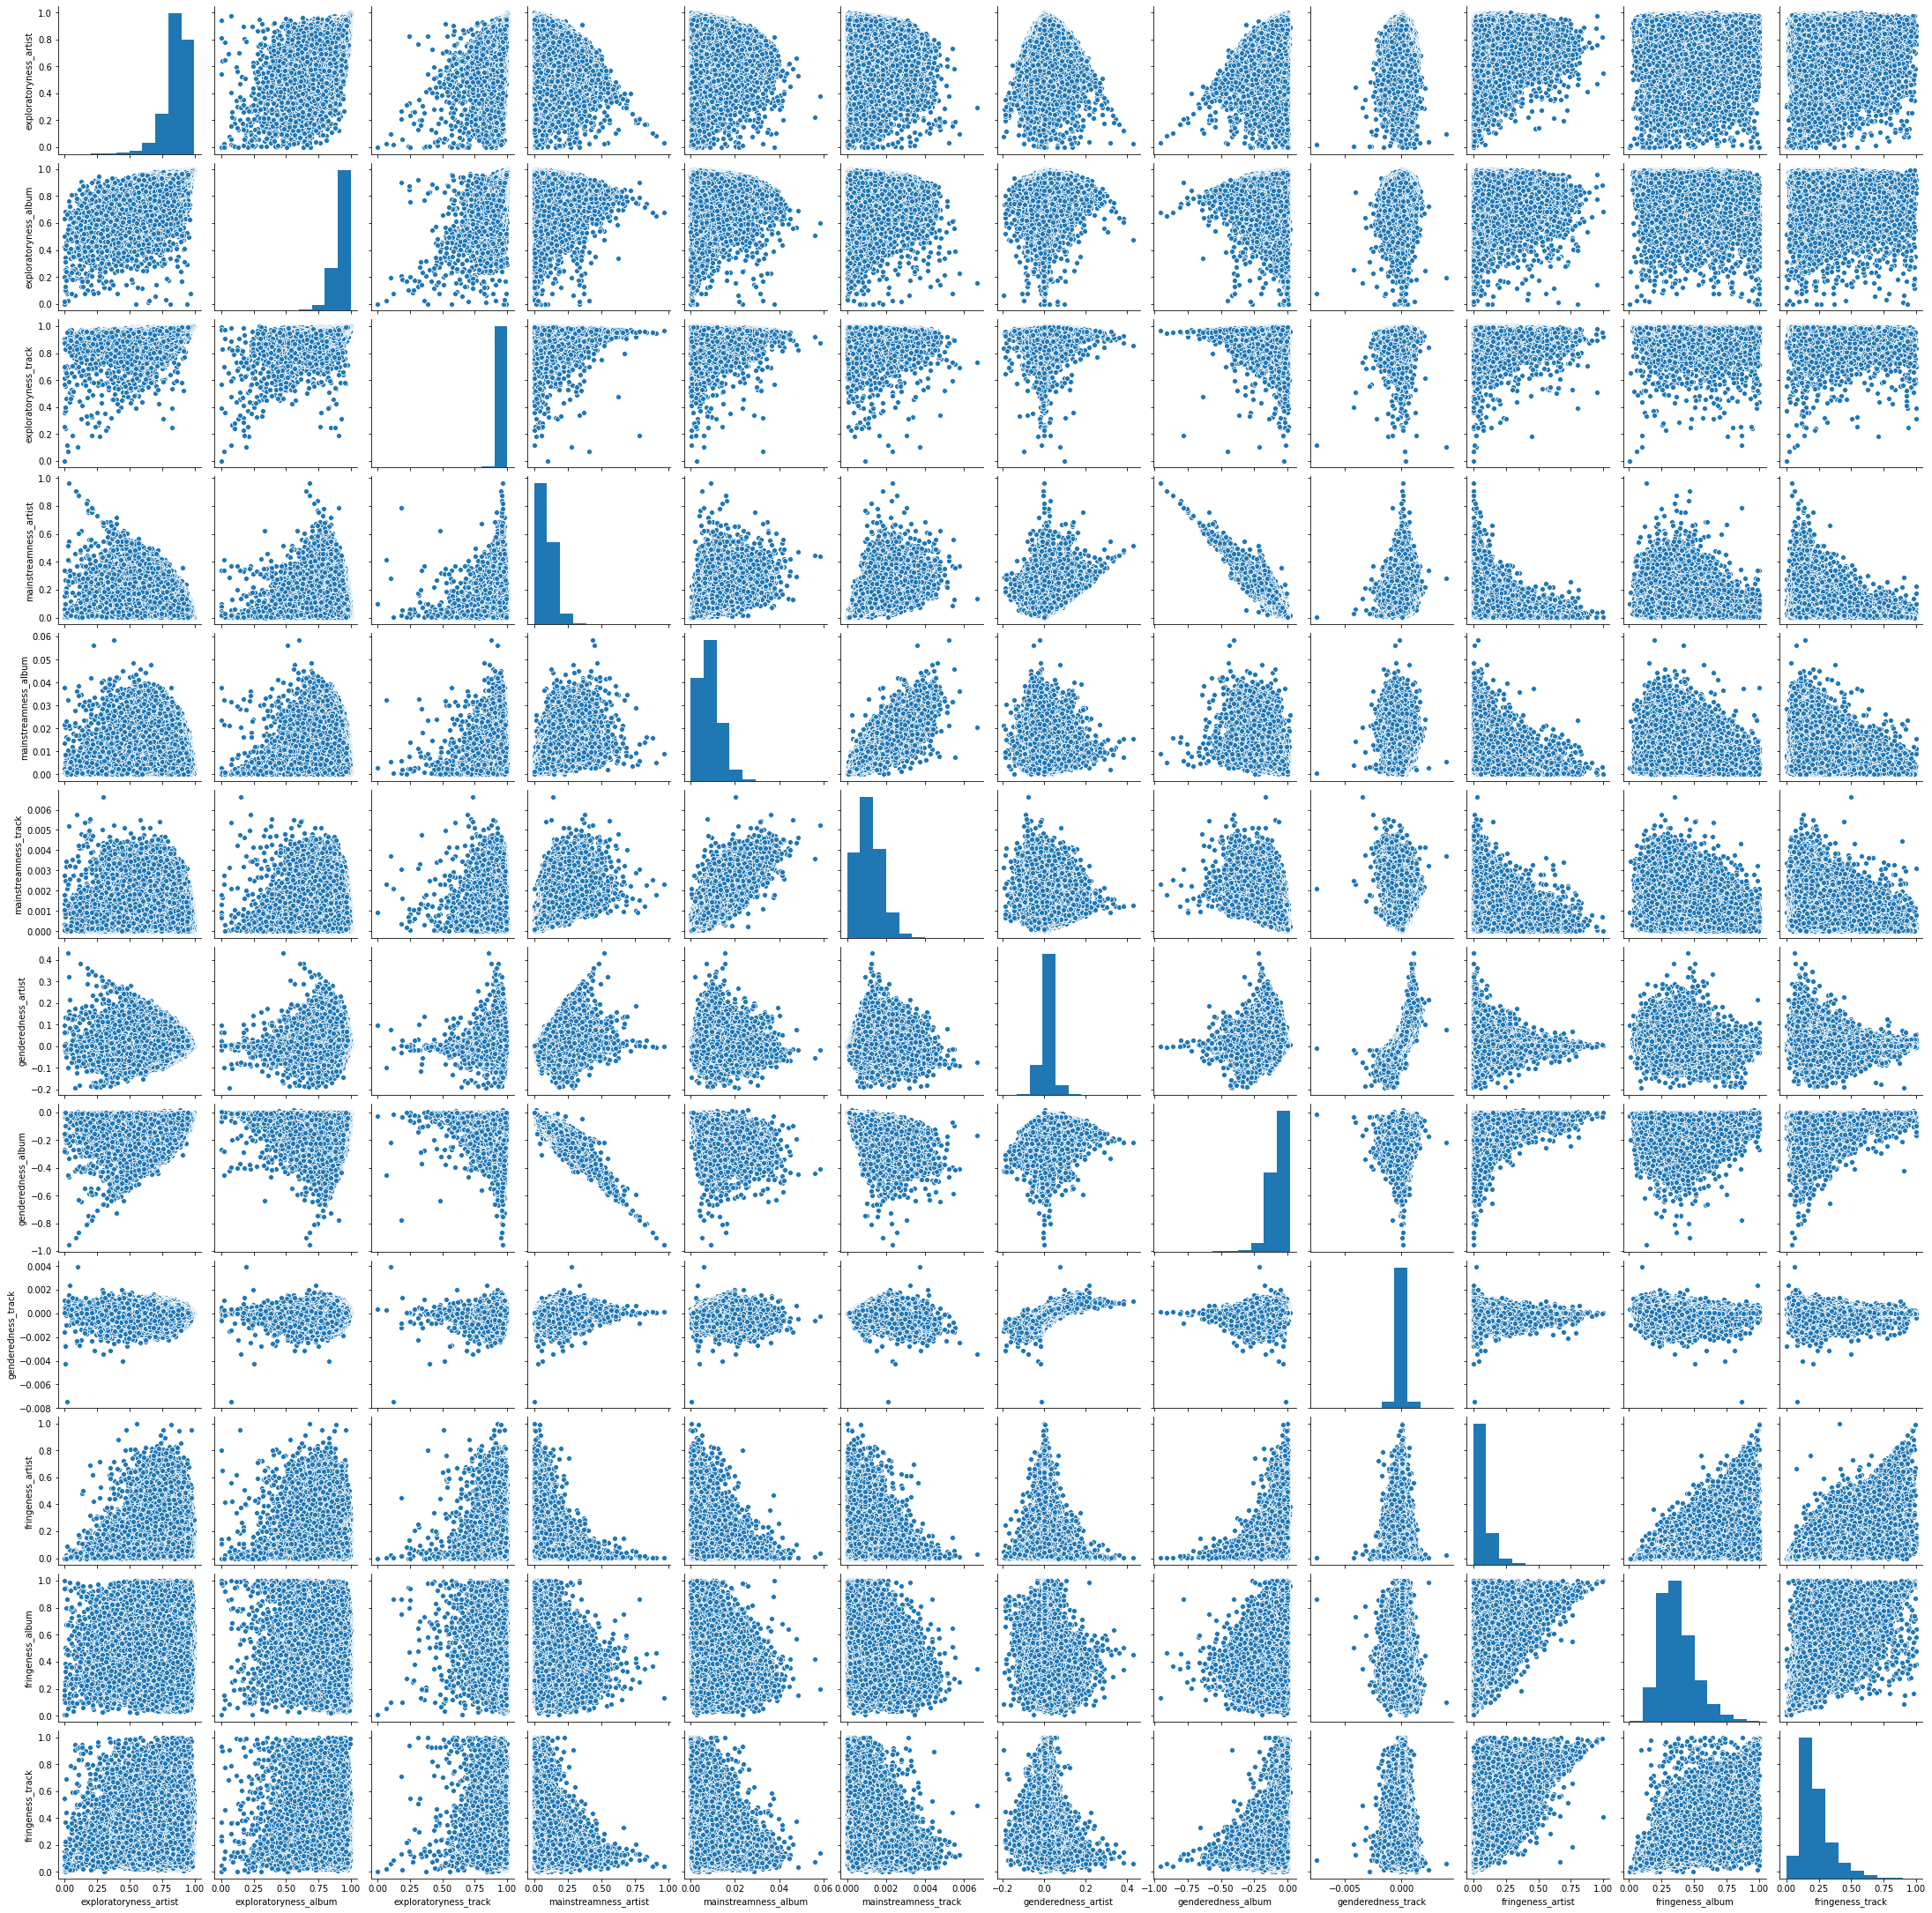

In [6]:
sns.pairplot(df)